In [173]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch_geometric.nn as gnn
import pickle
from tqdm import tqdm
import numpy as np
from torch.functional import F
import matplotlib.pyplot as plt
import math


with open("data/concat_graph/train_graphs_data.pkl", "rb") as file:
    graphs = pickle.load(file)
    file.close()

In [162]:
len(graphs), graphs[0]

(84, Data(x=[7980, 33], edge_index=[2, 85761], y=[7980, 2]))

In [163]:
graphs[0].y[0]

tensor([-0.2741, -0.6940])

In [164]:
# # 划分训练集和验证集，使用sklearn的train_test_split函数
# from sklearn.model_selection import train_test_split

# train_graphs, val_graphs = train_test_split(graphs, test_size=0.1, random_state=42)
val_len = graphs[0].x.shape[0] // 1140
test_len = val_len
train_graphs = graphs[: -val_len - test_len]
val_graphs = graphs[-val_len - test_len : -test_len]
test_graphs = graphs[-test_len:]
len(train_graphs), len(val_graphs), len(test_graphs)

(70, 7, 7)

In [165]:
class SAGEModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(SAGEModel, self).__init__()

        self.graph_features = nn.ModuleList(
            [
                gnn.SAGEConv(input_size, 128),
                nn.LayerNorm(128),
                nn.ReLU(),
                gnn.SAGEConv(128, 128),
                nn.LayerNorm(128),
                nn.ReLU(),
                gnn.SAGEConv(128, 128),
                nn.LayerNorm(128),
                nn.ReLU(),
            ]
        )

        # 考虑更多的trick，如layernorm等等
        self.regression = nn.Sequential(
            nn.Linear(128, 64),
            nn.LayerNorm(64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.LayerNorm(32),
            nn.ReLU(),
            nn.Dropout(0.02),
            nn.Linear(32, output_size),
        )

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        output = x

        for layer in self.graph_features:
            if isinstance(layer, gnn.SAGEConv):
                output = layer(output, edge_index)
            else:
                output = layer(output)

        output = self.regression(output)

        return output

In [166]:
# 看看模型的输入输出
model = SAGEModel(input_size=33, output_size=2)
output = model(graphs[0])
output.shape

torch.Size([7980, 2])

In [167]:
input_size = graphs[0].x.shape[1]
# 这里的output_size就是最终的输出维度，不需要再乘以num_heads
output_size = graphs[0].y.shape[1]
# 个人认为，注意力头的个数应该和输出维度保持一致，因为每个输出可能需要关注不同的邻居
num_heads = graphs[0].y.shape[1]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# batch_size = 256

# 开始训练

In [168]:
def train(
    model, criterion, optimizer, scheduler, train_graphs, val_graphs=None, num_epochs=50
):
    # 训练过程记录
    train_loss_list = []
    val_loss_list = []

    with tqdm(total=num_epochs, desc="Training Progress", unit="epoch") as pbar_epochs:
        for epoch in range(num_epochs):
            # 训练
            model.train()
            train_loss = 0.0

            # 目前每个batch是1个graph
            for i, graph in enumerate(train_graphs):
                graph = graph.to(device)

                output = model(graph)

                optimizer.zero_grad()
                loss = criterion(output, graph.y)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

            train_loss /= len(train_graphs)
            train_loss_list.append(train_loss)

            # 验证
            if val_graphs:
                model.eval()
                with torch.no_grad():
                    val_loss = 0.0
                    for i, graph in enumerate(val_graphs):
                        graph = graph.to(device)
                        output = model(graph)
                        loss = criterion(output, graph.y)
                        val_loss += loss.item()
                    val_loss /= len(val_graphs)
                    val_loss_list.append(val_loss)

            if val_graphs:
                pbar_epochs.set_postfix(
                    {
                        "train MSE Loss": train_loss,
                        "train score": val_loss,
                        "val MSE Loss": train_loss,
                        "val MSE Loss": val_loss,
                    }
                )
            else:
                pbar_epochs.set_postfix({"train MSE Loss": train_loss})

            pbar_epochs.update(1)
            # 学习率更新
            scheduler.step()

    # 可视化训练过程
    plt.figure()
    plt.plot(train_loss_list, label="train loss")
    if val_graphs:
        plt.plot(val_loss_list, label="val loss")
    plt.xlabel("epoch")
    plt.ylabel("MSE loss")
    plt.legend()

    return model

Training Progress:   0%|          | 0/150 [00:00<?, ?epoch/s]

Training Progress: 100%|██████████| 150/150 [01:31<00:00,  1.64epoch/s, train MSE Loss=0.00743, val MSE Loss=0.00909]


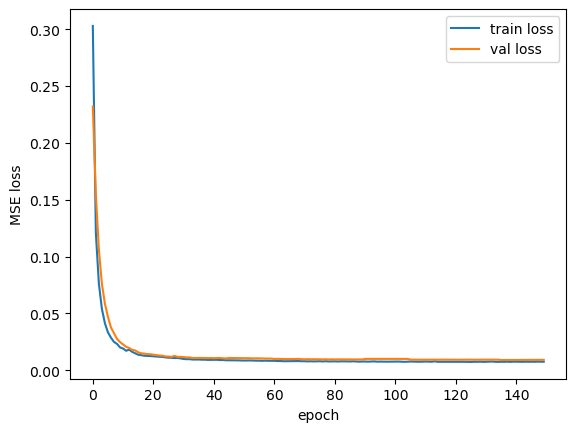

In [169]:
# 定义模型、算法、损失函数
model = SAGEModel(
    input_size=input_size,
    output_size=output_size,
).to(device)
# 考虑是否加入weight_decay
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
# 学习率衰减
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)
# criterion = nn.MSELoss(reduction="sum")
criterion = nn.MSELoss().to(device)

model = train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    train_graphs=train_graphs,
    val_graphs=val_graphs,
    num_epochs=150,
)

### 看看自定义测试集表现

In [174]:
def predict(model, test_graphs, test_len=-1):
    criterion = nn.MSELoss().to(device)
    model.eval()
    output_list = []
    total_loss = 0
    if test_len == -1:
        test_len = len(test_graphs)
    with torch.no_grad():
        for i, graph in enumerate(test_graphs[-test_len:]):
            graph = graph.to(device)
            output = model(graph)[-1140:, :]
            output_list.append(output)
            loss = criterion(output, graph.y[-1140:, :])
            total_loss += loss.item()
    total_loss /= test_len
    return output_list, total_loss, 1 / (1 + math.sqrt(total_loss))

In [175]:
output_list, loss, score = predict(model, test_graphs, test_len=4)
loss, score

(0.02604080270975828, 0.8610508254719917)

### 所有数据都训一训

In [172]:
# 定义模型、算法、损失函数
model = SAGEModel(
    input_size=input_size,
    output_size=output_size,
).to(device)
# 考虑是否加入weight_decay
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
# 学习率衰减
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)
# criterion = nn.MSELoss(reduction="sum")
criterion = nn.MSELoss().to(device)

model = train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    train_graphs=graphs,
    val_graphs=test_graphs,
    num_epochs=150,
)

Training Progress:   9%|▊         | 13/150 [00:09<01:38,  1.39epoch/s, train MSE Loss=0.0191, val MSE Loss=0.0138]


KeyboardInterrupt: 

### 保存模型

In [ ]:
# 保存模型
model_path = "saved/models/sage_concat.pth"

In [ ]:
torch.save(model, model_path)

# 预测

In [ ]:
# 读取模型
model = torch.load(model_path).to(device)

In [ ]:
# 读取node_ids
with open("data/concat_graph/node_ids.pkl", "rb") as file:
    node_ids = pickle.load(file)
    file.close()

In [ ]:
len(node_ids)

1140

In [ ]:
# 读取scaler
import pickle

with open("saved/scaler/label_scaler.pkl", "rb") as file:
    label_scaler = pickle.load(file)
    file.close()

In [ ]:
# 读取测试集
with open("data/concat_graph/test_graphs_data.pkl", "rb") as file:
    test_graphs = pickle.load(file)
    file.close()

In [ ]:
len(test_graphs), test_graphs[0], test_graphs[0].edge_index

(4,
 Data(x=[7980, 33], edge_index=[2, 99330]),
 tensor([[ 487,  669,  427,  ..., 6837, 6838, 6839],
         [ 496, 1013,  985,  ..., 7977, 7978, 7979]]))

预测

In [ ]:
output_list = []

with torch.no_grad():
    for i, graph in enumerate(test_graphs):
        graph = graph.to(device)
        output = model(graph)[-1140:, :]
        output = output.cpu().numpy()
        output_list.append(output)

In [ ]:
len(output_list), output_list[0].shape, output_list[0][0]

(4, (1140, 2), array([-0.46471435, -1.0171436 ], dtype=float32))

In [ ]:
# 缩放
output_list = [label_scaler.inverse_transform(output) for output in output_list]

In [181]:
label_scaler.mean_, np.sqrt(label_scaler.var_)

(array([70.24729331, 69.80525068]), array([3.43374468, 8.68131852]))

In [ ]:
# 看看是不是缩放完成啦
output_list[0][0]

array([68.65158, 60.9751 ], dtype=float32)

### 把输出转成需要的格式

In [ ]:
import csv

# 结果写入csv，分隔符为\t
output_path = "output/sage_concat_out.csv"

date_id = [20230404, 20230405, 20230406, 20230407]
with open(output_path, "w", newline="") as f:
    writer = csv.writer(f, delimiter="\t")  # 设置分隔符为制表符
    writer.writerow(["geohash_id", "consumption_level", "activity_level", "date_id"])

    # output_list.shape = [4天, 节点数, 2个输出]
    for nidx in range(len(node_ids)):
        for day in range(len(date_id)):
            # 注意不要写反了
            writer.writerow(
                [
                    node_ids[nidx],
                    output_list[day][nidx][1],
                    output_list[day][nidx][0],
                    date_id[day],
                ]
            )
    f.close()